In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
import os
try:
	os.chdir(os.path.join(os.getcwd(), '../..'))
	print(os.getcwd())
except:
	pass


In [1]:
import folium
import geopandas
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import pykrige as pk


In [3]:
dat = pd.read_csv('/Users/mfjkou/sengokuLab/study/LDAT_LS_2019/data/dev/csv/house_price_raw.csv')
mdat = pd.read_csv('/Users/mfjkou/sengokuLab/study/LDAT_LS_2019/data/dev/csv/house_price_pred.csv')


In [4]:
mdat.head()

,px,py,price,station,tokyo
0,139.402984,35.767626,NaN,0.017537,0.374249
1,139.407036,35.767626,NaN,0.013571,0.370307
2,139.411089,35.767626,NaN,0.009675,0.366367
3,139.439457,35.767626,NaN,0.001584,0.338865
4,139.394878,35.763700,NaN,0.026327,0.381271


 ## バリオグラム推定

 ### バリオグラム雲
 - packageに実装なし
 - 別途調査・実装

 ### 経験バリオグラム

 ## Regression kriging
 - pykrige packageのRegression krigingはsklearnのモデルのみ受け取る
 - バリオグラム単体を表示・操作するクラスはなく, krigingクラスにvariogramの操作機能が包括されている

In [5]:
from sklearn.linear_model import LinearRegression


In [6]:
model = LinearRegression(fit_intercept=False)


In [7]:
def transform_data(data, columns_latlon, columns_indep):
    '''
    Change the data format to use in kriging
    Input: list of columns:latlon and independent variable
    Output: values in np.array
    '''
    latlon = data[columns_latlon].values
    indeps = data[columns_indep].values
    return latlon, indeps


In [8]:
latlon, prop = transform_data(dat, ['px', 'py'], ['station', 'tokyo'])
mlatlon, mprop = transform_data(mdat, ['px', 'py'], ['station', 'tokyo'])

In [9]:
latlon, prop = transform_data(dat, ['px', 'py'], ['station', 'tokyo'])
mlatlon, mprop = transform_data(mdat, ['px', 'py'], ['station', 'tokyo'])
y = dat['price'].apply(lambda x: np.log(x)).values

In [10]:
y


array([11.9381932 , 12.05524976, 12.28765263, 12.06104687, 12.01370075,
       12.15477935, 12.14950229, 12.23076526, 12.4874851 , 12.41714362,
       12.18075484, 12.01974307, 12.34147728, 12.03171926, 12.14950229,
       12.23076526, 12.35879373, 12.13350195, 12.1388639 , 12.20607265,
       11.81303006, 12.2010601 , 12.25486281, 12.33710091, 12.08390501,
       12.3327053 , 11.91839057, 12.18075484, 12.30591798, 12.17561344,
       12.44114477, 12.46071486, 12.15477935, 11.94470788, 12.35449265,
       12.29682701, 12.14950229, 12.56723749, 12.60819885, 12.10625231,
       12.16525065, 12.16525065, 12.60148742, 12.02574909, 12.00150548,
       11.9381932 , 12.86876062, 12.23076526, 12.08390501, 12.00150548,
       12.38002595, 11.71993963, 12.19602231, 12.63785506, 12.38002595,
       12.00762171, 12.21602298, 11.89818787, 12.79107767, 12.02574909,
       12.26904744, 12.18586994, 12.6791964 , 11.97035031, 12.40081672,
       12.7628272 , 12.16525065, 11.9511804 , 12.39669301, 11.87

In [11]:
from pykrige.rk import RegressionKriging
gmodel = RegressionKriging(regression_model=model,  variogram_model='exponential', nlags=15)


In [12]:
gmodel.fit(prop, latlon, y)


Finished learning regression model
Finished kriging residuals


In [14]:
my = gmodel.predict(mprop, mlatlon)
print(my)


[12.63291266 12.23845812 11.87260946 11.6689488  13.23492107 12.87736253
 12.66492093 12.26097668 11.88436102 11.62359781 11.53878428 11.58319791
 11.80894766 11.89203102 11.90733777 11.81242483 11.97584795 11.73073961
 11.74825965 11.78803024 11.91669121 12.0314618  11.97788051 11.96561484
 11.97168956 11.8358395  11.87262235 11.89394267 12.05556529 11.9781703
 11.94714832 11.99630178 11.93880805 12.04955993 11.96499049 11.94955143
 11.94532416 11.99272049 11.99705217 11.99134327 12.05757367 12.09431199
 12.1115346  11.95277379 11.97987771 12.04733982 12.0331345  11.98930763
 12.07922454 12.07167762 12.07955801 12.07453368 12.18144358 12.06129242
 12.10288681 12.21309819 12.23836073 12.17526537 12.19878952 12.23575655
 12.16596551 12.13295504 12.61731533 12.12674875 12.16258422 12.26295404
 12.3523282  12.30576674 12.30747109 12.26517632 12.20359111 12.19413337
 12.77771802 12.41234934 12.13604063 12.12456389 12.24004112 12.39075863
 12.36667458 12.19737808 12.25385783 12.3651574  12.

In [16]:
# LOO cross validation
pred_list = []
for i in range(0,len(dat)):
    dsub = dat.drop(i)
    msub = dat.iloc[i:i+1, :]

    dprop = dsub[['station', 'tokyo']].values
    dlatlon = dsub[['px', 'py']].values
    dy = dsub['price'].apply(lambda x: np.log(x)).values

    m_prop = msub[['station', 'tokyo']].values
    m_latlon = msub[['px', 'py']].values
    gmodel.fit(dprop, dlatlon, dy)
    pred = gmodel.predict(m_prop, m_latlon)
    pred_list.append(pred)


Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished learning regression model
Finished kriging residuals
Finished

In [17]:
len(pred_list)


128

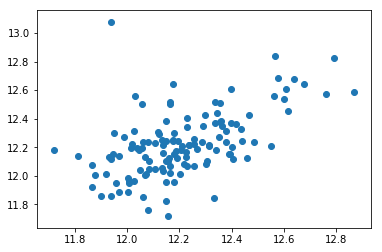

In [77]:
plt.scatter(y, pred_list)
plt.ylim = (11.8, 12.8)
plt.savefig('/Users/mfjkou/sengokuLab/study/LDAT_LS_2019/data/dev/plot/res_pykrige.png')
#Rよりも精度が低い. なぜ?

In [19]:
mdat['price'] = my


In [20]:
mdat.head()



,px,py,price,station,tokyo
0,139.402984,35.767626,12.632913,0.017537,0.374249
1,139.407036,35.767626,12.238458,0.013571,0.370307
2,139.411089,35.767626,11.872609,0.009675,0.366367
3,139.439457,35.767626,11.668949,0.001584,0.338865
4,139.394878,35.763700,13.234921,0.026327,0.381271


In [21]:
import folium
import geopandas
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import pykrige as pk

from shapely.geometry import Point


In [25]:
# geopandas型にする
mdat['Coordinates'] = list(zip(mdat.px, mdat.py))
mdat['Coordinates'] = mdat['Coordinates'].apply(Point)

In [23]:
mdat.head()

,px,py,price,station,tokyo,Coordinates
0,139.402984,35.767626,12.632913,0.017537,0.374249,POINT (139.4029835 35.7676260119048)
1,139.407036,35.767626,12.238458,0.013571,0.370307,POINT (139.4070361 35.7676260119048)
2,139.411089,35.767626,11.872609,0.009675,0.366367,POINT (139.4110887 35.7676260119048)
3,139.439457,35.767626,11.668949,0.001584,0.338865,POINT (139.4394569 35.7676260119048)
4,139.394878,35.763700,13.234921,0.026327,0.381271,POINT (139.3948783 35.76370003571429)


In [24]:
gmdat = geopandas.GeoDataFrame(mdat, geometry='Coordinates')


In [25]:
gmdat.head()

,px,py,price,station,tokyo,Coordinates
0,139.402984,35.767626,12.632913,0.017537,0.374249,POINT (139.4029835 35.7676260119048)
1,139.407036,35.767626,12.238458,0.013571,0.370307,POINT (139.4070361 35.7676260119048)
2,139.411089,35.767626,11.872609,0.009675,0.366367,POINT (139.4110887 35.7676260119048)
3,139.439457,35.767626,11.668949,0.001584,0.338865,POINT (139.4394569 35.7676260119048)
4,139.394878,35.763700,13.234921,0.026327,0.381271,POINT (139.3948783 35.76370003571429)


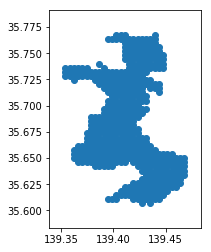

In [26]:
gmdat.plot()

In [27]:
gmdat.price

0      12.632913
1      12.238458
2      11.872609
3      11.668949
4      13.234921
5      12.877363
6      12.664921
7      12.260977
8      11.884361
9      11.623598
10     11.538784
11     11.583198
12     11.808948
13     11.892031
14     11.907338
15     11.812425
16     11.975848
17     11.730740
18     11.748260
19     11.788030
20     11.916691
21     12.031462
22     11.977881
23     11.965615
24     11.971690
25     11.835839
26     11.872622
27     11.893943
28     12.055565
29     11.978170
         ...    
510    11.961115
511    12.087450
512    12.139152
513    12.043823
514    12.049676
515    12.098219
516    12.454975
517    12.198368
518    12.151997
519    12.164077
520    12.213239
521    12.124499
522    12.019082
523    12.017021
524    12.078365
525    12.206272
526    12.134138
527    12.139450
528    12.835015
529    12.833856
530    12.579320
531    12.299686
532    12.284864
533    12.139670
534    12.098659
535    12.149877
536    12.311573
537    12.2862

In [28]:
gmdat.price.describe()


count    540.000000
mean      12.206771
std        0.225002
min       11.538784
25%       12.045619
50%       12.192004
75%       12.338092
max       13.234921
Name: price, dtype: float64

## 可視化する

In [29]:
np.linspace(gmdat['price'].min(), gmdat['price'].max(), 10)

array([11.53878428, 11.72724393, 11.91570357, 12.10416321, 12.29262286,
       12.4810825 , 12.66954214, 12.85800179, 13.04646143, 13.23492107])

In [30]:
def set_rang(data, column, num):
    max_val = data[column].max()
    min_val = data[column].min()
    rang = np.linspace(min_val, max_val, num=num)
    return rang

In [31]:
rang = set_rang (gmdat, 'price', 10)

In [32]:
gmdat_list = []
for i in range(0, len(rang)):
    if i< 9:
        g = gmdat[(gmdat['price'] >= rang[i]) & (gmdat['price'] < rang[i+1])]
    else:
        g = gmdat[gmdat['price'] >= rang[i]]
    gmdat_list.append(g)


In [33]:
gmdat_list = []
for i in range(0, len(rang)):
    if i< 9:
        g = gmdat[(gmdat['price'] >= rang[i]) & (gmdat['price'] < rang[i+1])]
    else:
        g = gmdat[gmdat['price'] >= rang[i]]
    gmdat_list.append(g)


In [34]:
np.linspace(0.1, 1, len(rang))

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [35]:
[str(round(x,2)) for x in np.linspace(0.1, 1, len(rang))]

['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']

In [36]:
color_list = [str(round(x,2)) for x in np.linspace(0.1, 1, len(rang))]

In [58]:
print(gmdat_list)

[            px         py      price   station     tokyo  \
3   139.439457  35.767626  11.668949  0.001584  0.338865   
9   139.415141  35.763700  11.623598  0.008722  0.361515   
10  139.419194  35.763700  11.538784  0.007156  0.357570   
11  139.423247  35.763700  11.583198  0.007694  0.353628   

                              Coordinates  
3    POINT (139.4394569 35.7676260119048)  
9   POINT (139.4151413 35.76370003571429)  
10  POINT (139.4191939 35.76370003571429)  
11  POINT (139.4232465 35.76370003571429)  ,              px         py      price   station     tokyo  \
2    139.411089  35.767626  11.872609  0.009675  0.366367   
8    139.411089  35.763700  11.884361  0.011566  0.365462   
12   139.427299  35.763700  11.808948  0.010001  0.349688   
13   139.431352  35.763700  11.892031  0.010321  0.345751   
14   139.435404  35.763700  11.907338  0.007163  0.341817   
15   139.439457  35.763700  11.812425  0.003868  0.337886   
17   139.415141  35.759774  11.730740  0.012128  0

No handles with labels found to put in legend.


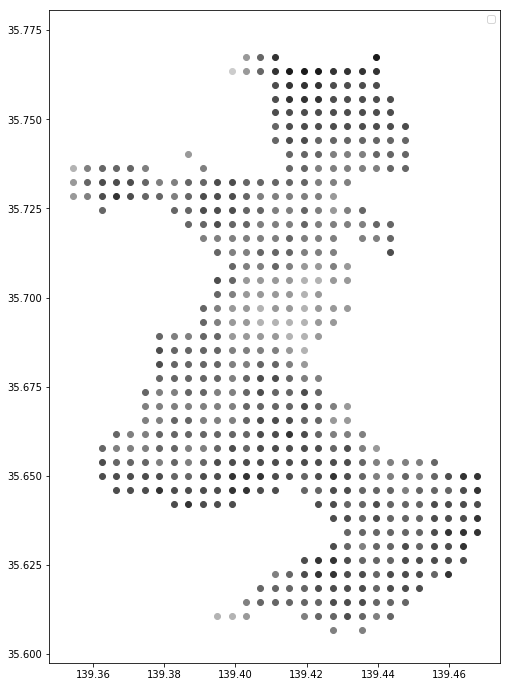

In [38]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1)
for i in range(0, len(gmdat_list)):
    gmdat_list[i].plot(ax=ax, color = color_list[i])
ax.legend()



In [39]:
rang = set_rang (gmdat, 'price', 8)


In [41]:
gmdat_list = []
for i in range(0, len(rang)):
    if i< len(rang)-1:
        g = gmdat[(gmdat['price'] >= rang[i]) & (gmdat['price'] < rang[i+1])]
    else:
        g = gmdat[gmdat['price'] >= rang[i]]
    gmdat_list.append(g)


In [42]:
color_list = [str(round(x,2)) for x in np.linspace(0.1, 1, len(rang))]

In [43]:
print(color_list)

['0.1', '0.23', '0.36', '0.49', '0.61', '0.74', '0.87', '1.0']


No handles with labels found to put in legend.


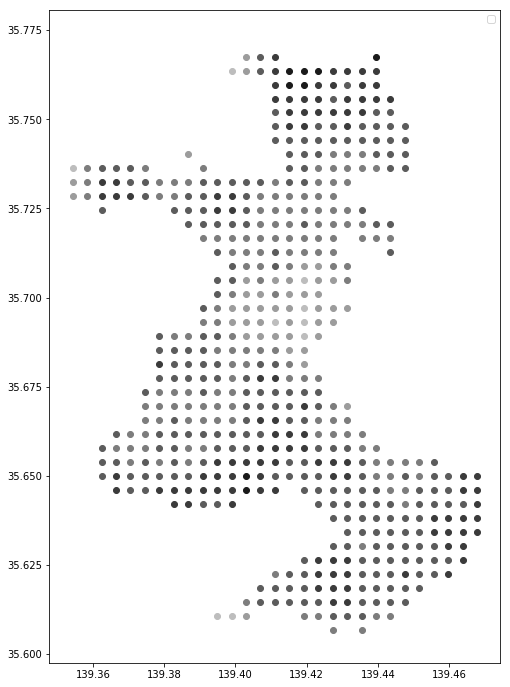

In [44]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1)
for i in range(0, len(gmdat_list)):
    gmdat_list[i].plot(ax=ax, color = color_list[i])
ax.legend()



In [71]:
fig.savefig('/Users/mfjkou/sengokuLab/study/LDAT_LS_2019/data/dev/plot/test.png')


In [69]:
rang = set_rang(gmdat, 'price', 8)

In [70]:
gmdat_list = []
for i in range(0, len(rang)):
    if i< len(rang)-1:
        g = gmdat[(gmdat['price'] >= rang[i]) & (gmdat['price'] < rang[i+1])]
    else:
        g = gmdat[gmdat['price'] >= rang[i]]
    gmdat_list.append(g)


In [71]:
color_list = [str(round(x,2)) for x in np.linspace(0.1, 0.9, len(rang))]

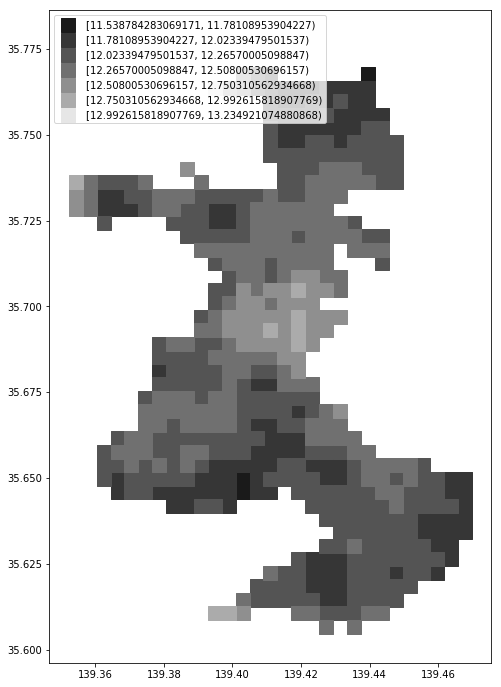

In [76]:
fig = plt.figure(figsize=(12,12))
ax.patch.set_facecolor('white')
ax = fig.add_subplot(1,1,1)
for i in range(0, len(gmdat_list)):
    gmdat_list[i].plot(ax=ax, color = color_list[i], marker='s', markersize = 170)
ax.legend(['[{0}, {1})'.format(rang[i], rang[i+1]) for i in range(0, len(rang)-1)],loc='upper left')

#Rで実装したversionとはかなり異なる

In [68]:
fig.savefig('/Users/mfjkou/sengokuLab/study/LDAT_LS_2019/data/dev/plot/test.png')


In [78]:
def plot_kriging_res(gmdat, column, rang):
    ''''
    '''
    color_list = [str(round(x,2)) for x in np.linspace(0.1, 0.9, len(rang))]
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(1,1,1)
    for i in range(0, len(rang)):
        if i< len(rang)-1:
            g = gmdat[(gmdat[column] >= rang[i]) & (gmdat[column] < rang[i+1])]
        else:
            g = gmdat[gmdat[column] >= rang[i]]
        g.plot(ax=ax, color = color_list[i], marker='s', markersize=170)
    ax.legend(['[{0}, {1})'.format(rang[i], rang[i+1]) for i in range(0, len(rang)-1)],loc='best')

    return fig

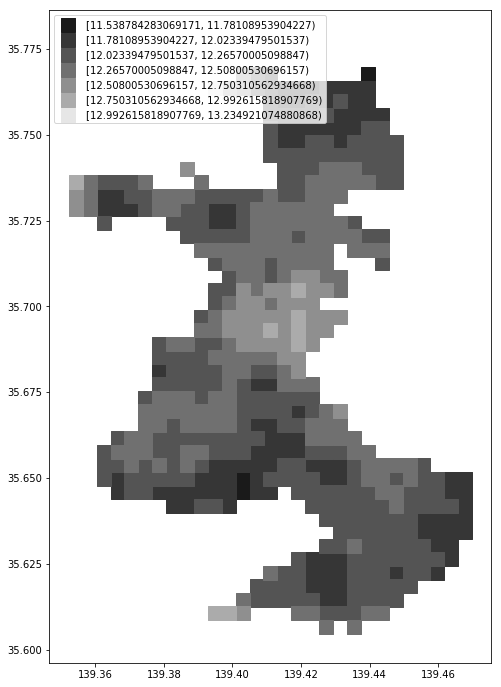

In [79]:
res_fig = plot_kriging_res(gmdat, 'price', rang)

## 残差の2乗をプロットする

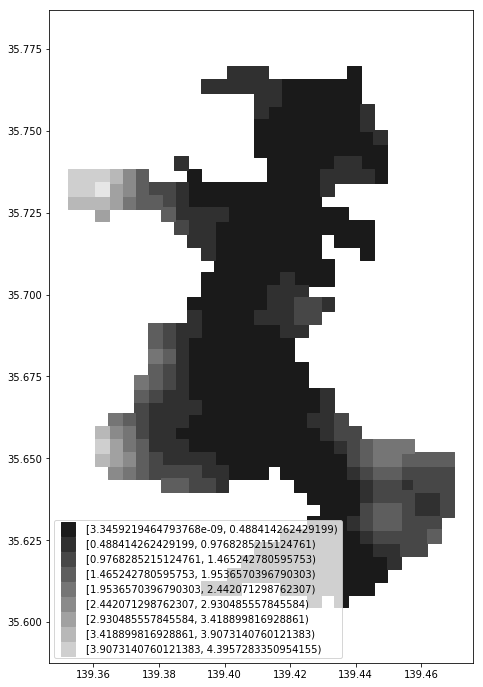

In [80]:
gmdat['sq_resid'] = gmodel.krige_residual(mlatlon)**2
rang = set_rang(gmdat, 'sq_resid', 10)
sq_resid_fig = plot_kriging_res(gmdat, 'sq_resid', rang)
#やはりRで実装した場合と異なってしまう